# Extended Haldane Hamiltonian

In [51]:
import numpy as np
import numpy.linalg as la
from numpy import sqrt , sin, cos, pi
from scipy.linalg import eig 
import matplotlib as mpl
import matplotlib.pyplot as plt

"Pauli matrices"
sigma0 = np.eye(2)
sigmax = np.array([[0,1],[1,0]])
sigmay = np.array([[0,-1j],[1j,0]])
sigmaz = np.array([[1,0],[0,-1]])

f0001 = np.array([[0,0,0,1],[0,0,0,0],[0,0,0,0],[0,0,0,0]])
f0010 = np.array([[0,0,0,0],[0,0,1,0],[0,0,0,0],[0,0,0,0]])
f0100 = np.array([[0,0,0,0],[0,0,0,0],[0,1,0,0],[0,0,0,0]])
f1000 = np.array([[0,0,0,0],[0,0,0,0],[0,0,0,0],[1,0,0,0]])

"Useful operations and values"
def Rmat(A): #rotations by A radians
    return np.array([[np.cos(A),np.sin(A)],[-np.sin(A),np.cos(A)]])
def dag(U): #dagger
    return np.transpose(np.conj(U))
def cc(U):  #complex conjugation
    return np.conj(U)
s3 = np.sqrt(3)
pi = np.pi


def Haldane3(kvec, params):
    """
    This is a version of the Haldane Chern insulator, with a TRS copy.
    I have now also added a third-nearest neighbour hopping (t3)! (https://arxiv.org/pdf/1605.04768.pdf)
    The real-space unit cell used here is C3 symmetric, unlike in the arXiv above.
    Note that I've set the primary hopping parameter t1 == 1, for simplicity.
    I've also fixed phi to be pi/2.
    Basic model explanation can be found at URL: https://topocondmat.org/w4_haldane/haldane_model.html
    """ 
    if params == []:
        phi, m, t1, t2, t3, l_R = [pi/2, 0.1, 1, 0.1, 0, 0]
    else: 
        phi, m, t1, t2, t3, l_R = params
    
    
    "Lattice vectors"
    a1 = np.array([0  , 1])
    a2 = np.array([np.sqrt(3)/2 , -1/2])
    a3 = -a1-a2
    b1= a2-a1
    b2 = a3-a2
    b3 = a1-a3
    c1 = a1+a2-a3
    c2 = -a1+a2+a3
    c3 = a1-a2+a3
    
    "Products of kvec with lattice vectors"
    ka1 = np.dot(kvec,a1)
    ka2 = np.dot(kvec,a2)
    ka3 = np.dot(kvec,a3)
    kb1 = np.dot(kvec,b1)
    kb2 = np.dot(kvec,b2)
    kb3 = np.dot(kvec,b3)
    kc1 = np.dot(kvec,c1)
    kc2 = np.dot(kvec,c2)
    kc3 = np.dot(kvec,c3)
    
    d1 = t1*(np.cos(ka1) + np.cos(ka2) + np.cos(ka3)) + t3*(np.cos(kc1) + np.cos(kc2) + np.cos(kc3))
    d2 = t1*(- np.sin(ka1) - np.sin(ka2) - np.sin(ka3)) + t3*(-np.sin(kc1) - np.sin(kc2) - np.sin(kc3)) 
    d3 = m + 2*t2*(np.sin(kb1) + np.sin(kb2) + np.sin(kb3))
    d3_ = m - 2*t2*(np.sin(kb1) + np.sin(kb2) + np.sin(kb3)) #time-reversed copy
    
    H  = d1*sigmax + d2*sigmay + d3*sigmaz
    H2 = d1*sigmax + d2*sigmay + d3_*sigmaz 
    
    Hupleft = np.kron(0.5*(sigma0+sigmaz), H)
    Hlowright = np.kron(0.5*(sigma0-sigmaz),H2)
    
    "Spin-orbit coupling that preserves TRS & C3 symmetry" 
    "Third-nn Rashba SOC:"
    ras1 = (-1j+s3)*np.exp(1j*kc1) + 2*1j*np.exp(1j*kc2) + (-1j - s3)*np.exp(1j*kc3)
    ras2 = (-1j-s3)*np.exp(1j*kc1) + 2*1j*np.exp(1j*kc2) + (-1j + s3)*np.exp(1j*kc3)

    H_R3 = l_R*(ras1*f0001 + cc(ras2)*f0010 + ras2*f0100 + cc(ras1)*f1000) #3rd nn Rashba SOC
    
    return H_R3 + Hupleft + Hlowright 


def GetEvalsAndEvecs(HF):
    """
    Get e-vals and e-vecs of Hamiltonian HF.
    Order Evals and correspoinding evecs by smallest eval first.
    Set the gauge for each evec; choosing the first non-zero element to be real and positive.
    Note that the gauge may be changed later by multiplying any vec arbitrarily by a phase. 
    """
    #order by evals, also order corresponding evecs
    evals, evecs = eig(HF)
    idx = np.real(evals).argsort()
    evals = evals[idx]
    evecs = evecs[:,idx]
    
    #make first element of evecs real and positive
    for vec in range(np.size(HF[0])):
        
        # Find first element of the first eigenvector that is not zero
        firstNonZero = (evecs[:,vec]!=0).argmax()
        #find the conjugate phase of this element
        conjugatePhase = np.conj(evecs[firstNonZero,vec])/np.abs(evecs[firstNonZero,vec])
        #multiply all elements by the conjugate phase
        evecs[:,vec] = conjugatePhase*evecs[:,vec]

    # check that the evals are real
    if np.all((np.round(np.imag(evals),7) == 0)) == True:
        return np.real(evals), evecs
    else:
        x =  evals[np.argsort(np.imag(evals))[0]]
        #print('evals are imaginary! e.g.', f"{x:.3}")
        return evals, evecs
    
    
def BerryCurvature(Hamiltonian, k, params):
    
    h = 0.0001
    
    H = Hamiltonian(k,params)
    
    d0,v0 = GetEvalsAndEvecs(H)
                
    #first eigenvector
    u0=v0[:,0]
    
    #eigenvalues
    band1 = d0[0]
    band2 = d0[1] 
    band3 = d0[2]
    band4 = d0[3]
    
    #dx direction
    kxx = k + np.array([h,0])
    H = Hamiltonian(kxx, params)
    dx,vx = GetEvalsAndEvecs(H)
    ux = vx[:,0] # first eigenvector
    
    #dy direction
    kyy = k+np.array([0,h])
    H = Hamiltonian(kyy, params)
    dy,vy = GetEvalsAndEvecs(H)
    uy=vy[:,0] # first eigenvector

    xder = (ux-u0)/h
    yder = (uy-u0)/h
    
    berrycurve = 2*np.imag(np.dot(np.conj(xder), yder))
    
    return berrycurve, band1, band2, band3, band4

# Calculate gaps

In [44]:
def MinGap(Ham, params, N):
    "Ham is the Hamiltonian, params the parameters, and N the number of steps taken along each k-direction in the grid"
    kx_path = np.linspace(-np.pi, np.pi, N)
    ky_path = np.linspace(-np.pi, np.pi, N)
    H = Ham((0,0), params)
    n = H.shape[0]
    evals = la.eigh(H)[0]
    gap = np.abs(evals[n//2]- evals[n//2 -1])
    for kx in kx_path:
        for ky in ky_path:
            evals = la.eigh(Ham((kx,ky), params))[0]
            gap_n = np.abs(evals[n//2]- evals[n//2 -1])
            if gap_n < gap:
                gap = gap_n
    return gap

phi = pi/2
t1 = 1
m = 0.1
l_R = 0.3
Nt = 20
Nk = 100
gaps = np.empty((Nt,Nt))
for i, t2 in enumerate(np.linspace(0,1,Nt)):
    for j, t3 in enumerate(np.linspace(0,1,Nt)):
        params = [phi, m, t1, t2, t3, l_R]
        gap = MinGap(Haldane3, params, Nk)
        gaps[i,j] = gap
        

# Plot gaps

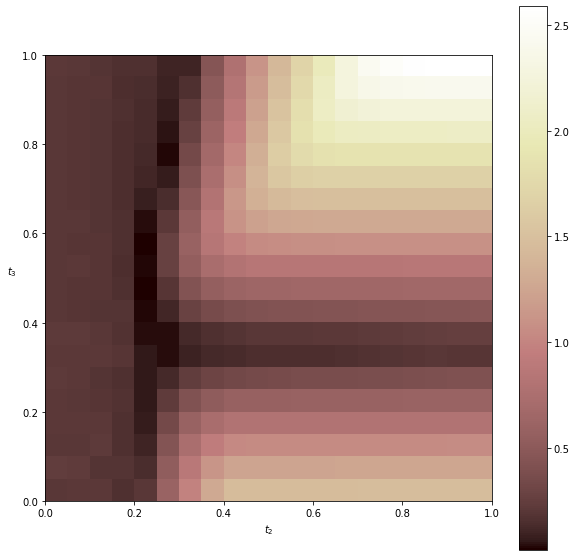

In [46]:
gmin = np.min(gaps)
#norm =mpl.colors.LogNorm(vmin=gmin, vmax=1.0)
norm = mpl.colors.Normalize(vmin=np.min(gaps), vmax=np.max(gaps))
cmap = "pink"

sz = 10
fig, ax = plt.subplots(figsize=(sz,sz))
pcm = ax.imshow(np.real(np.flip(np.transpose(gaps), axis=0)), 
                interpolation='none', cmap=cmap, 
                norm=norm, extent=[0,1,0,1])
ax.tick_params(axis="x", bottom=True, top=False, labelbottom=True, 
  labeltop=False)  
ax.set_xlabel(r'$t_2$')
ax.set_ylabel(r'$t_3$', rotation=0, labelpad=10)
# cax = plt.axes([1.03, 0.1, 0.03, 0.8])
fig.colorbar(pcm)
plt.show()

##  Plot Bandstructure

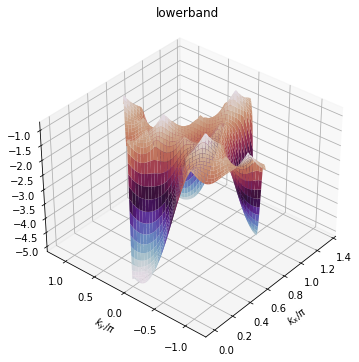

In [11]:
"""lower band"""
fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection='3d')
ax.view_init(35, -140)
ax.plot_surface(kx/pi, ky/pi, np.real(lowerband), cmap=cmap)
ax.set_title('lowerband')
ax.set_xlabel(r'$k_x/\pi$')
ax.set_ylabel(r'$k_y/\pi$')
plt.show()  

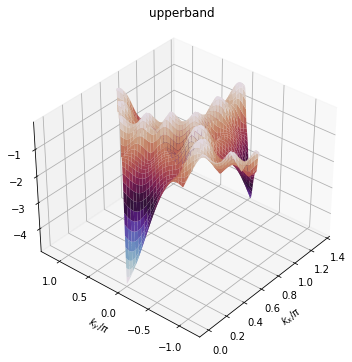

In [12]:
"""upperband"""
fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection='3d')
ax.view_init(35, -140)
ax.plot_surface(kx/pi, ky/pi, np.real(upperband), cmap=cmap)#, norm=normaliser)
ax.set_title('upperband')
ax.set_xlabel(r'$k_x/\pi$')
ax.set_ylabel(r'$k_y/\pi$')
plt.show() 

# Calculate Bandstructure and Berry Curvature

In [25]:
phi = pi/2
t1 = 1
t2 = 0.6
t3 = 0.6
m = 0.1
l_R = 0.3
params = [phi, m, t1, t2, t3, l_R]

#reciprocal lattice vectors
r1 = (2*pi/(3))*np.array([1, sqrt(3)])
r2 = (2*pi/(3))*np.array([1, -sqrt(3)])

dlt = 0.005
u10 = np.linspace(0, 1, int(1/dlt + 1), endpoint=True)
u20=u10
qpoints = len(u10)
u1, u2 = np.meshgrid(u10, u20)
kx = u1*r1[0] + u2*r2[0]
ky = u1*r1[1] + u2*r2[1]

jacobian = dlt**2*(4*pi/3)**2*sin(pi/3)

berrycurve = np.empty([qpoints, qpoints], dtype=np.complex128)
band1 = np.empty([qpoints, qpoints], dtype=np.complex128)
band2 = np.empty([qpoints, qpoints], dtype=np.complex128)

for xcnt in range(len(u10)):
    for ycnt in range(len(u10)):
        
        #pick momentum point in meshgrid
        k = np.array([kx[xcnt, ycnt], ky[xcnt,ycnt]])
        
        bC, lB, uB, _, _ = BerryCurvature(Haldane3, k, params)
        berrycurve[xcnt, ycnt] = bC
        band1[xcnt, ycnt] = lB
        band2[xcnt, ycnt] = uB

chernnumber = (1/2/pi)*np.sum(berrycurve[:-1,:-1])*jacobian



## Plot Berry curvature

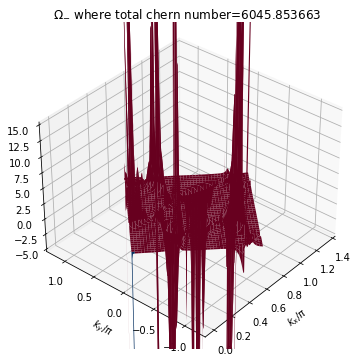

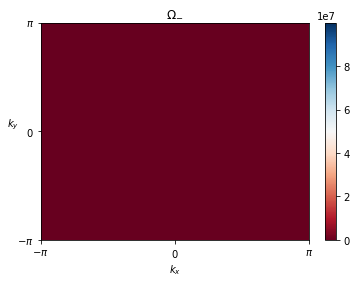

In [43]:
cmapstring = 'twilight'
cmap = mpl.cm.get_cmap(cmapstring)

"""plot berry curve"""
fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection='3d')
ax.view_init(35, -140)
ax.plot_surface(kx/pi, ky/pi, np.real(berrycurve), cmap="RdBu")

ax.set_zlim([-5, 15])
ax.set_title(r"$\Omega_{-}$" + " where total chern number="+str(np.round(np.real(chernnumber), 6)))
ax.set_xlabel(r'$k_x/\pi$', labelpad=5)
ax.set_ylabel(r'$k_y/\pi$', labelpad=5)
plt.show()       



"""plot berry curve"""
fig, ax = plt.subplots()
img = ax.imshow(np.real(np.flip(np.transpose(berrycurve), axis=0)), 
                cmap="RdBu", aspect="auto",
                interpolation='none', extent=[-pi,pi,-pi,pi])
ax.set_title(r"$\Omega_{-}$")
ax.set_xlabel(r"$k_x$")
label_list = [r'$-\pi$', r"$0$", r"$\pi$"]
ax.set_xticks([-pi,0,pi])
ax.set_yticks([-pi,0,pi])
ax.set_xticklabels(label_list)
ax.set_yticklabels(label_list)
ax.set_ylabel(r"$k_y$", rotation=0)
fig.colorbar(img)
plt.show()


# Create k-path

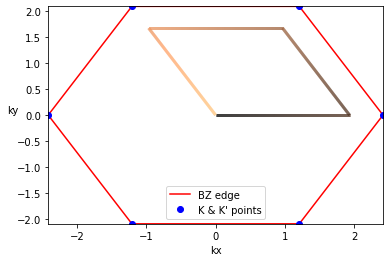

In [54]:
"""
Definitions of the BZ points
"""
G =    np.array([0,0])                          #Gamma

K_1 =  np.array([ 2*pi/(3*s3), 2*pi/3])       # Right upper K
K_p1 = np.array([4*pi/(3*s3),  0])            # Rightmost K'
K_2 =  np.array([2*pi/(3*s3),  -2*pi/3])      # Right lower K
K_p2 = np.array([-2*pi/(3*s3), -2*pi/3])      # Left lower K'
K_3 =  np.array([-4*pi/(3*s3),  0])           # Leftmost K
K_p3 = np.array([-2*pi/(3*s3),  2*pi/3])      # Left upper K'

M_1 =  np.array([0,      2*pi/3])             # Uppermost M
M_2 =  np.array([pi/s3,  pi/3])               # Right upper M
M_3 =  np.array([pi/s3,  -pi/3])              # Right lower M
M_4 =  np.array([0,      -2*pi/3])            # Lowest M
M_5 =  np.array([-pi/s3, -pi/3])              # Left lower M
M_6 =  np.array([-pi/s3, pi/3])               # Left upper M

def KPath(point_list, loop=True, N=200):
    '''
    This function produces the path connecting the set of points given in the point_list input.
    The path will be closed if loop is True and will be open if False.
    N is the number of points between subsequent points in point_list in the path.
    One can check the stability of the result by increasing N further.
    '''
    k_trajectory = np.empty([0,2])
    k_trajectory = np.append(k_trajectory,np.linspace(point_list[0],point_list[0],1),axis=0)
    for i in range(len(point_list)-1):
        segment = np.linspace(point_list[i], point_list[i+1], N)[1:] #note: requires numpy version > 1.15
        k_trajectory = np.append(k_trajectory, segment, axis=0)
    if loop==True:
        segment = np.linspace(point_list[-1], point_list[0], N)[1:]
        k_trajectory = np.append(k_trajectory, segment, axis=0)
    return k_trajectory

# for plotting k-path

from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

def MakeSegments(x, y):
    '''
    Create list of line segments from x and y coordinates, in the correct format for LineCollection:
    an array of the form   numlines x (points per line) x 2 (x and y) array
    '''
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    return segments

def ColorLine(x, y, z=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0), linewidth=3, alpha=1.0):
    '''
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    '''
    
    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))
           
    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])
        
    z = np.asarray(z)
    
    segments = MakeSegments(x, y)
    lc = LineCollection(segments, array=z, cmap=cmap, norm=norm, linewidth=linewidth, alpha=alpha)
    
    ax = plt.gca()
    ax.add_collection(lc)
    
    return lc


# define k-line
width = 0.8
pointlist = [G, width*K_p1, width*K_1, width*K_p3]
k_path = KPath(pointlist, loop=True, N=200)

# define boundary of the BZ
boundarypoints = np.asarray([K_p1, K_1, K_p3, K_3, K_p2, K_2])
boundaryline = KPath(boundarypoints, loop=True, N=200)


# Plot k-path w.r.t BZ
fig, axes = plt.subplots()
ColorLine(k_path[:,0], k_path[:,1])
plt.xlim(-4*pi/(3*s3)  , 4*pi/(3*s3) )
plt.ylim(-2*pi/3,2*pi/3)
plt.plot(boundaryline[:,0], boundaryline[:,1], 'r', label='BZ edge')
plt.plot(boundarypoints[:,0], boundarypoints[:,1], 'bo', label="K & K' points")
plt.xlabel("kx")
plt.ylabel("ky", rotation=0)
plt.legend()
plt.show()



# Wilson Lines

In [56]:
from scipy.linalg import expm

def AbelianCalcWilsonLine(evecsFinal, evecsInitial, dgbands=4):
    wilsonLineAbelian = np.zeros([dgbands, dgbands], dtype=np.complex128)
    for n0 in range(dgbands):
        for n1 in range(dgbands):
            wilsonLineAbelian[n0,n1] = np.vdot(evecsFinal[:,n1], evecsInitial[:,n0])
    return wilsonLineAbelian

def CalculateBerryConnect(Hamiltonian, k, params, n0, n1):
    
    h = 0.0001;
    
    H = Hamiltonian(k, params)
    evals, evecs = GetEvalsAndEvecs(H)
    
    #first eigenvector
    u0 = evecs[:,n0]
    u1 = evecs[:,n1]
    
    #dx direction
    H = Hamiltonian(k +np.array([h,0]), params)
    _,evecsX = GetEvalsAndEvecs(H)
    ux1 = evecsX[:,n1]
 
    #dy direction
    H = Hamiltonian(k + np.array([0,h]), params)
    _,evecsY = GetEvalsAndEvecs(H)
    uy1=evecsY[:,n1]

    xdiff = (ux1-u1)/h
    ydiff = (uy1-u1)/h
    
    berryConnect = 1j*np.array([np.dot(np.conj(u0),xdiff),np.dot(np.conj(u0),ydiff)])

    return berryConnect


def CalculateBerryConnectMatrix(Hamiltonian, k, params, dgbands=4):
    """
    """
    # dimension is dgbands x dgbands x 2, for dx and dy
    berryConnect = np.zeros((dgbands,dgbands, 2), dtype=np.complex128)
    for n0 in range(dgbands):
        for n1 in range(dgbands):
            berryConnect[n0,n1] = CalculateBerryConnect(Hamiltonian, k, params, n0, n1)
    return berryConnect

def DifferenceLine(array2D):
    """
    Find the difference between each point in an array
    (this is used for differentiation)
    """
    X = np.append(np.append(array2D[[-2]], array2D, axis=0), array2D[[1]], axis=0)
    xDiff = np.zeros((len(array2D), 2))
    for i in range(len(array2D)):
        xDiff[i] = np.array([X[i+2,0] - X[i,0], X[i+2,1] - X[i,1]])
    return xDiff


'''
Calculate Wilson Line - Abelian
'''
width = 0.7
pointlist = [G, width*K_p1, width*K_1, width*K_p3]
k_path = KPath(pointlist, loop=True, N=200)
dqs = DifferenceLine(k_path)

k0 = k_path[0]
totalPoints = len(k_path)
H = Haldane3(k0, params)
_, evecsInitial = GetEvalsAndEvecs(H)

wilsonLineAbelian = np.empty([totalPoints, 4,4], dtype=np.complex128)
# go through possible end points for k
for i, kpoint in enumerate(k_path):
    #Find evec at k point, calculate Wilson Line abelian method
    H = Haldane3(kpoint, params)
    _, evecsFinal = GetEvalsAndEvecs(H)
    wilsonLineAbelian[i] = AbelianCalcWilsonLine(evecsFinal, evecsInitial)
    
    

"""
Calculate Wilson Line - Non Abelian
"""

wilsonLineNonAbelian = np.zeros([totalPoints, 4, 4], dtype=np.complex128)
currentArgument = np.zeros([4,4], dtype=np.complex128)

for i, kpoint in enumerate(k_path):
    berryConnect = CalculateBerryConnectMatrix(Haldane3, kpoint, params)
    dq = dqs[i]
    berryConnectAlongKLine =  1j*np.dot(berryConnect, dq)
    currentArgument = currentArgument + berryConnectAlongKLine
    wilsonLineNonAbelian[i] = expm(currentArgument)
    
  

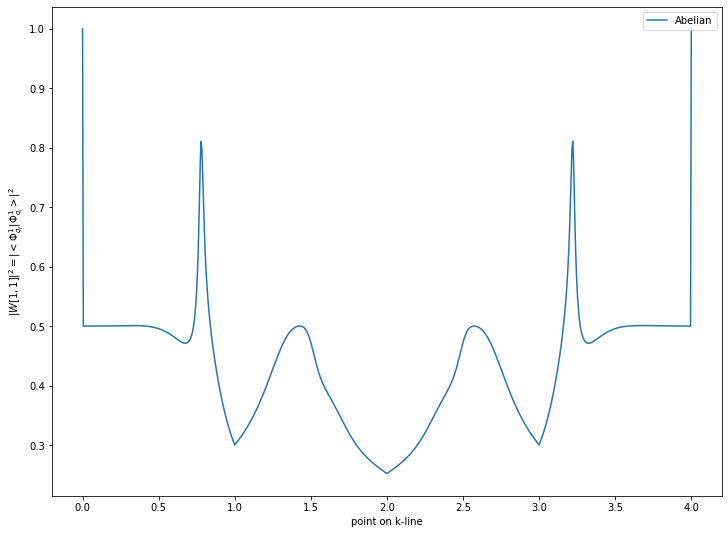

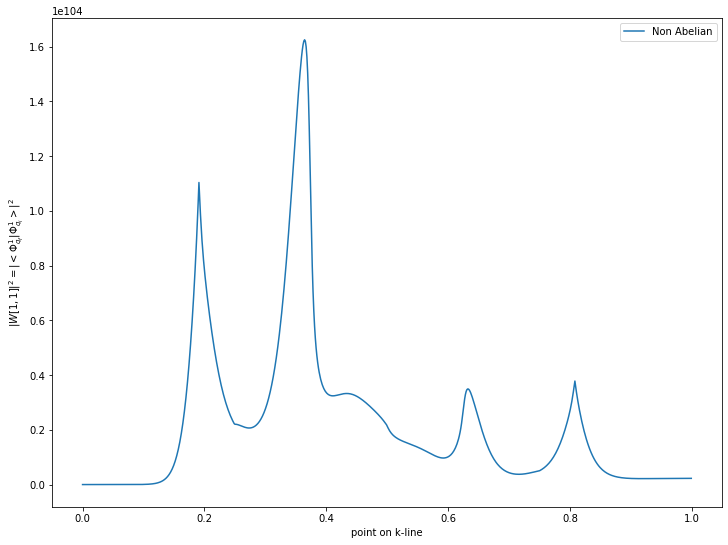

In [66]:
  
'''
Plot elements of the Wilson Line
'''

m1 = 1
m2 = 1
multiplier = np.linspace(0,4,totalPoints)
fig, ax = plt.subplots(figsize=(12,9))
ax.plot(multiplier, np.square(np.abs(wilsonLineAbelian[:,m1,m2])), label="Abelian")
# ax.plot(multiplier, np.square(np.abs(wilsonLineNonAbelian[:,m1,m2])), label="Non Abelian")
ax.set_ylabel(r"$|W["+str(m1) +","+str(m2)+"]|^2 = |<\Phi_{q_f}^"+str(m1)+" | \Phi_{q_i}^"+str(m2)+">|^2$")
ax.set_xlabel("point on k-line")
plt.legend(loc="upper right")
plt.show()   


m1 = 1
m2 = 1
multiplier = np.linspace(0,1,totalPoints)
fig, ax = plt.subplots(figsize=(12,9))
# ax.plot(multiplier, np.square(np.abs(wilsonLineAbelian[:,m1,m2])), label="Abelian")
ax.plot(multiplier[:-1], np.square(np.abs(wilsonLineNonAbelian[:,m1,m2]))[:-1], label="Non Abelian")
ax.set_ylabel(r"$|W["+str(m1) +","+str(m2)+"]|^2 = |<\Phi_{q_f}^"+str(m1)+" | \Phi_{q_i}^"+str(m2)+">|^2$")
ax.set_xlabel("point on k-line")
plt.legend(loc="upper right")
plt.show()   


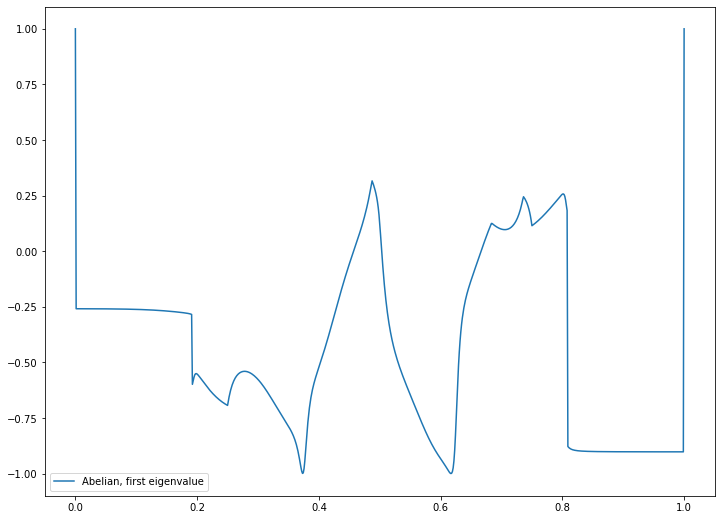

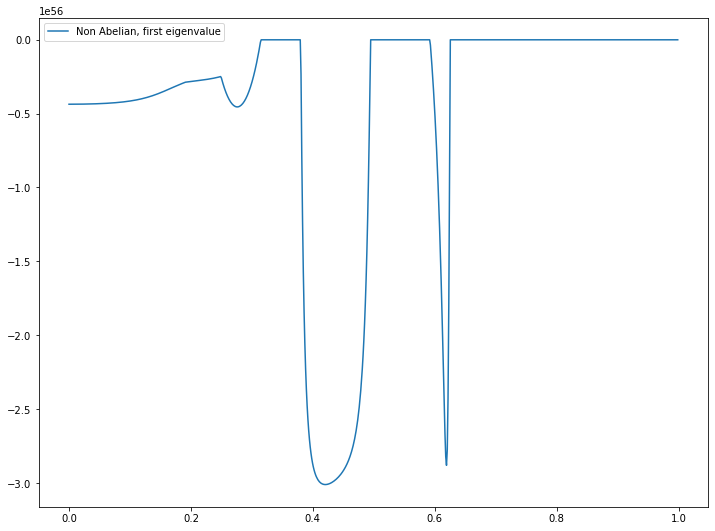

In [65]:

"""
Eigenvalue flow
""" 

evalsAbelian = np.empty((totalPoints, 4), dtype=np.complex128)
evalsNonAbelian = np.empty((totalPoints, 4), dtype=np.complex128)
for i in range(totalPoints):
    evalsA, _ = GetEvalsAndEvecs(wilsonLineAbelian[i,:,:])
    evalsNA, _ = GetEvalsAndEvecs(wilsonLineNonAbelian[i,:,:])
    evalsNonAbelian[i] = evalsNA
    evalsAbelian[i] = evalsA

fig, ax = plt.subplots(figsize=(12,9))
# ax.plot(multiplier, np.real(evalsNonAbelian[:,0]), label="Non Abelian, first eigenvalue")
ax.plot(multiplier, np.real(evalsAbelian[:,0]), label="Abelian, first eigenvalue")
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(12,9))
ax.plot(multiplier[:-1], np.real(evalsNonAbelian[:,0])[:-1], label="Non Abelian, first eigenvalue")
# ax.plot(multiplier, np.real(evalsAbelian[:,0]), label="Abelian, first eigenvalue")
plt.legend()
plt.show()